In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms as tt

from matplotlib import pyplot as plt
import numpy as np

/nfs/helium2/arjun/.conda/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get transform
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(trainset[i][0]) for i in range(len(testset))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

print(mean)
print(std)

Files already downloaded and verified
Files already downloaded and verified
[0.5058918137254902, 0.4859552125459559, 0.4411151014859069]
[0.26766681344702586, 0.2560914330229496, 0.27595397525087484]


In [3]:
'''
Step 1: Download dataset & set up data loader
Luckly no custom dataset is needed, we can use CIFAR100 dataset from torchvision
'''

# Define the transformation using the calculated mean and std
mean = [0.5059, 0.4860, 0.4411]
std = [0.2677, 0.2561, 0.2759]
transform_train = tt.Compose([
                         tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(mean,std,inplace=True)
						 ])

transform_test = tt.Compose([
                            tt.ToTensor(), 
							 tt.Normalize(mean,std)
							 ])

# define the datasets
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)


# define the datasets
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
test_loader = DataLoader(testset, batch_size=4, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32]) torch.Size([4])


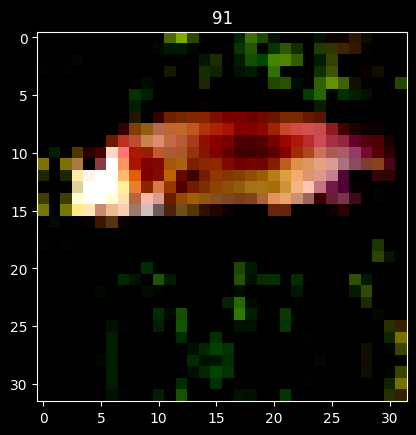

In [4]:
'''
Step 1.1: lets test the dataloader
'''

for images, labels in train_loader:
    print(images.size(), labels.size())
    plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
    plt.title(labels[0].item())
    plt.show()

    break


In [5]:
'''
Step 2: Define the model
'''

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [7]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the appropriate device

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy:.2f}%')

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_loss = running_val_loss / len(val_loader)
        validation_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy:.2f}%')

# Assuming model, train_loader, val_loader, criterion, optimizer are defined
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)


100%|██████████| 12500/12500 [01:03<00:00, 197.58it/s]


Epoch 1, Training Loss: 3.4542848709011076, Training Accuracy: 16.62%


Epochs:  10%|█         | 1/10 [01:07<10:04, 67.17s/it]

Epoch 1, Validation Loss: 3.1756845607280733, Validation Accuracy: 21.20%


100%|██████████| 12500/12500 [01:07<00:00, 184.94it/s]


Epoch 2, Training Loss: 3.038341246329546, Training Accuracy: 24.06%


Epochs:  20%|██        | 2/10 [02:18<09:17, 69.75s/it]

Epoch 2, Validation Loss: 2.8311093807935714, Validation Accuracy: 28.70%


100%|██████████| 12500/12500 [01:03<00:00, 196.75it/s]


Epoch 3, Training Loss: 2.7520762230420113, Training Accuracy: 29.76%


Epochs:  30%|███       | 3/10 [03:26<08:01, 68.74s/it]

Epoch 3, Validation Loss: 2.4562228275835514, Validation Accuracy: 36.08%


100%|██████████| 12500/12500 [01:02<00:00, 198.68it/s]


Epoch 4, Training Loss: 2.546048914480209, Training Accuracy: 34.20%


Epochs:  40%|████      | 4/10 [04:33<06:47, 67.99s/it]

Epoch 4, Validation Loss: 2.3877445827424526, Validation Accuracy: 38.20%


100%|██████████| 12500/12500 [01:16<00:00, 163.45it/s]


Epoch 5, Training Loss: 2.3865801280647516, Training Accuracy: 37.67%


Epochs:  50%|█████     | 5/10 [05:53<06:02, 72.53s/it]

Epoch 5, Validation Loss: 2.2164074676454066, Validation Accuracy: 41.57%


100%|██████████| 12500/12500 [01:07<00:00, 185.46it/s]


Epoch 6, Training Loss: 2.252488233047724, Training Accuracy: 40.53%


Epochs:  60%|██████    | 6/10 [07:05<04:48, 72.12s/it]

Epoch 6, Validation Loss: 2.1282087778404355, Validation Accuracy: 44.17%


100%|██████████| 12500/12500 [01:03<00:00, 195.92it/s]


Epoch 7, Training Loss: 2.1461055336129666, Training Accuracy: 42.80%


Epochs:  70%|███████   | 7/10 [08:12<03:32, 70.70s/it]

Epoch 7, Validation Loss: 2.1242535855829714, Validation Accuracy: 44.64%


100%|██████████| 12500/12500 [01:04<00:00, 193.34it/s]


Epoch 8, Training Loss: 2.066124326152727, Training Accuracy: 44.60%


Epochs:  80%|████████  | 8/10 [09:21<02:20, 70.07s/it]

Epoch 8, Validation Loss: 2.1192675586134193, Validation Accuracy: 44.55%


100%|██████████| 12500/12500 [01:06<00:00, 188.27it/s]


Epoch 9, Training Loss: 2.001886462891996, Training Accuracy: 46.01%


Epochs:  90%|█████████ | 9/10 [10:31<01:10, 70.15s/it]

Epoch 9, Validation Loss: 2.0886245472699403, Validation Accuracy: 45.27%


100%|██████████| 12500/12500 [01:03<00:00, 195.35it/s]


Epoch 10, Training Loss: 1.9489365218045562, Training Accuracy: 47.62%


Epochs: 100%|██████████| 10/10 [11:39<00:00, 69.98s/it]

Epoch 10, Validation Loss: 1.996133022941649, Validation Accuracy: 47.31%
